In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from collections import Counter
import random
%load_ext rpy2.ipython

In [2]:
%%R

# Setup R stuff

pacman::p_load(
tidyverse,forcats,
readxl,microbenchmark,
gapminder,broom,purrrlyr,knitr,DT, htmlTable,reshape2,R.matlab,httr)

In [ ]:
%%R

# this is required to load Envy Code R for the figures.

# pacman::p_load(extrafont,extrafontdb)
# font_import(prompt=FALSE)
# loadfonts()
# # full debugging cruft
# fonttable()

In [6]:
%%R -o beo

# This newer scansion was provided as a single string by the paper authors
# https://github.com/qcrit/NHB-2018-OEstylometry/blob/master/meter_and_compounds/Matlab%20code/BeoScansion.mat

raw <- readMat('src/BeoScansion.mat')
beo <- raw$wbeow
beo

     [,1]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [27]:
new_pats=list(beo[0])

In [92]:
# Process raw data - this is from the original paper data

# Basically the idea is that we have a list of half-line indicies where
# one of five patterns occurs. When reassembled, we'll have a long ordered
# string of half-line metrical patterns which gives us the scansion for Beowulf

# These txt files were extracted from the matlab data in BeowMeter.mat, which
# is missing the half-line index data for 'C'

d = {}
for idx, s in enumerate(['A','B', 'D', 'E']):
    a = np.loadtxt("src/scans/%sbeow.txt" % s, delimiter=',', dtype='int')
    dups = {k for k in a if k in d}
    if len(dups) > 0:
        raise RuntimeError("Duplicate found :(")
    # each half-line number in this file is added as a key with the value
    # being the metre string (A, B....)
    d.update((dict(zip(a, [s]*len(a)))))

In [23]:
# Half-lines that aren't there are assumed to be 'C'
for i in range(6267):
    if i not in d:
        d[i]='C'

In [28]:
# Now we have an ordered list of patterns
old_patterns = [a[1] for a in sorted(d.items())]
len(old_patterns)

6268

In [91]:
# These two scans are out of alignment, although they are essentially identical.
#
# Our initial analysis was performed on the data from BeoMeter.mat, so that is
# what is represented here.
#
# To be clear, NEITHER set of scansion patterns is correctly aligned. The newer
# patterns start correctly, but they are definitely out of alignment by line 100
# (based on our manual check). The older lines are correctly aligned at that point
# but not at the start. About 50 lines are also missing (6268 half lines is 3134 
# lines, but Beowulf has 3182. We did not investigate this further.

In [29]:
# The only difference between the old and new strings is a missing 'C'
# from the beginning and one added at the end.

(old_patterns[1:] + ['C']) == new_pats

True

In [30]:
# First let's replicate the NHB plot
res = []
ctr = Counter()
for x in range(len(old_patterns)):
    ctr[raw_patterns[x]]+=1
    res.append({'type':old_patterns[x], 'idx':x, 'count':ctr[old_patterns[x]]})
by_idx = pd.DataFrame(res)
by_idx.head(10)

type  idx  count
0    C    0      1
1    C    1      2
2    C    2      3
3    D    3      1
4    A    4      1
5    C    5      4
6    A    6      2
7    C    7      5
8    A    8      3
9    A    9      4

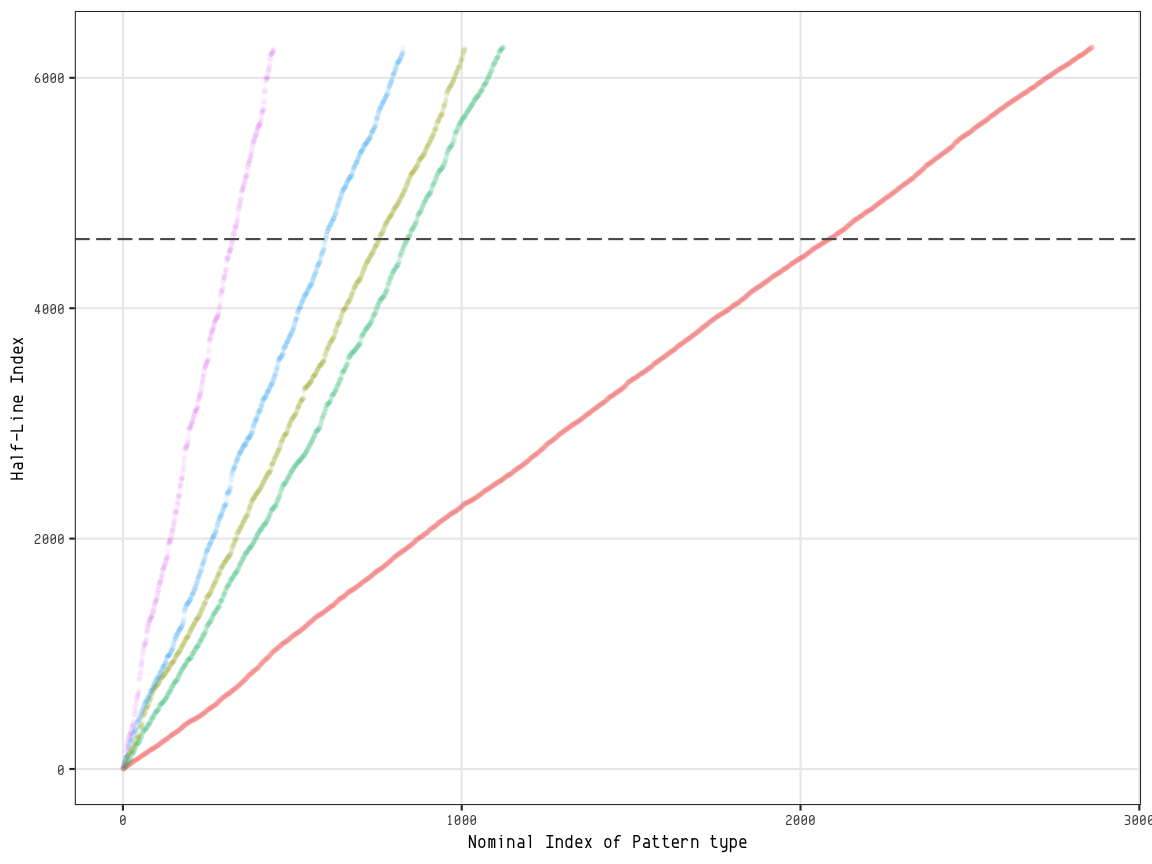

In [42]:
%%R -i by_idx -u in -h 6 -w 8 -r 144

ggplot(data=by_idx, aes(x=count,y=idx,color=type)) + 
geom_point(size=1, shape=16, alpha=1/13) +
geom_hline(yintercept=4600, linetype=5, color=grey(0.35)) +
theme_bw() +
labs(x="Nominal Index of Pattern type", y="Half-Line Index") +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.position='none')

In [99]:
# Disputed section starts at line 2300, half-line 4600

pre = raw_patterns[:4600]
post = raw_patterns[4600:]
beow = pre + post

In [100]:
# This is so that we can see if there is any substantial change with the
# revised scasion from the authors. This will make no visible difference 
# to any of the plots, but we'll double check the stats, later.

new_pre = new_pats[:4600]
new_post = new_pats[4600:]
new_beow = new_pre + new_post

In [95]:
# The first plot suggests that the rate of use for the patterns is pretty
# constant - but that's really just an artifact of the way it's graphed. Now
# I'll take a rolling window and look at the moving average of
# relative proportions of each pattern

CHUNKSZ=200
STEP=20
keys = set(beow)
res=[]
for x in range(0,len(beow)-CHUNKSZ,STEP):
    slice = beow[x:x+CHUNKSZ]
    ctr = Counter(slice)
    obs={'chunk':x/STEP}
    for k in keys:
        obs[k] = ctr[k]/CHUNKSZ
    res.append(obs)
common = [x[0] for x in Counter(beow).most_common()]
half_line_data = pd.DataFrame(res)[common + ['chunk']]

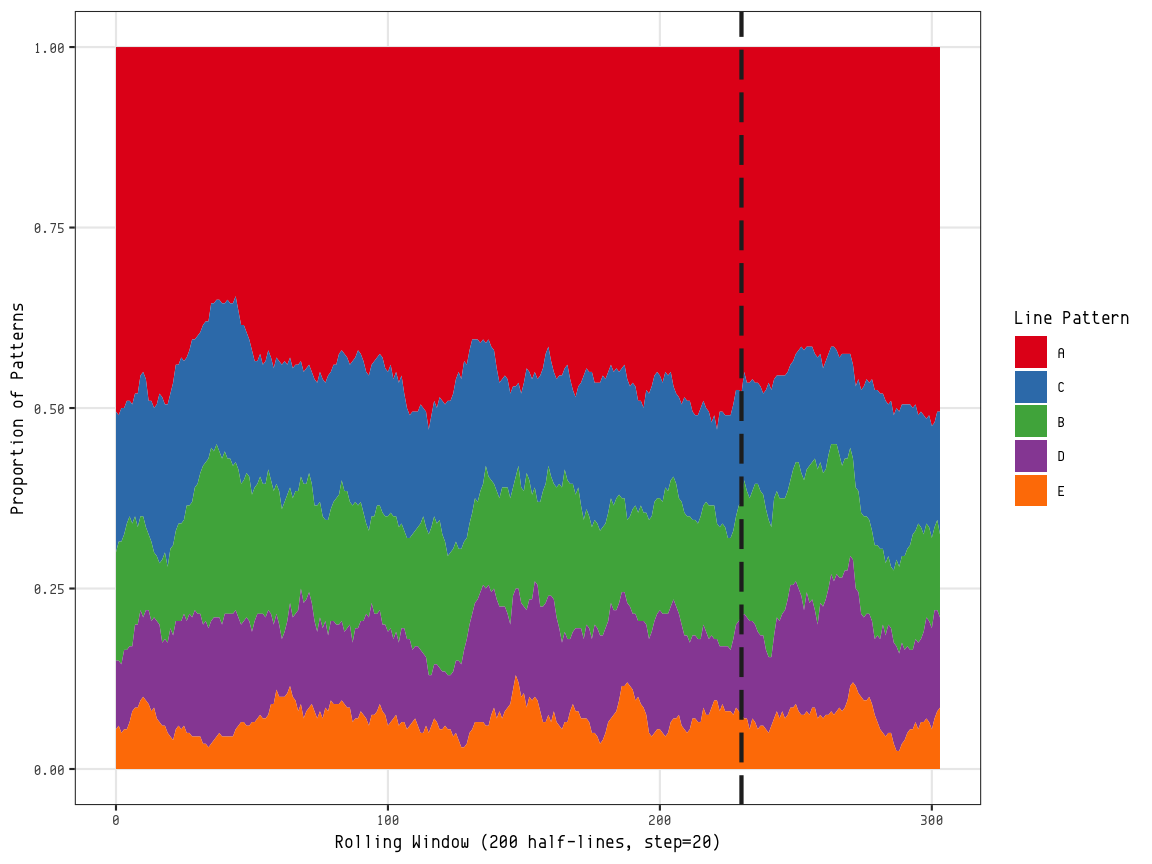

In [118]:
%%R -i half_line_data,STEP,CHUNKSZ -u in -w 8 -h 6 -r 144
library(RColorBrewer)
getPalette = colorRampPalette(brewer.pal(5, "Set1"))

df <- melt(half_line_data, id='chunk')
ggplot() + 
geom_area(position='stack', data=df, aes(x=chunk, y=value, fill=variable)) + 
geom_vline(xintercept = (4600)/STEP, col = grey(0.15), linetype=5, size = 1) +
theme_bw() +
labs(x="Rolling Window (200 half-lines, step=20)", y="Proportion of Patterns") +
scale_fill_manual(values = getPalette(5)) +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank()) + #, legend.position='none')
guides(fill=guide_legend("Line Pattern"))

In [45]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [46]:
def get_counts(ll, key_lines=None):
    '''
    Return the counts per pattern, in order.
    
    For subsets, pass key_lines so that we have
    all the possible keys (otherwise zero counts
    will be missed)
    '''
    if not key_lines:
        key_lines=ll
    ctr = Counter(ll)
    patterns = sorted(Counter(key_lines).keys())
    
    return(np.array([ctr[k] for k in patterns]))

In [47]:
get_counts(beow)

array([2862, 1010, 1123,  828,  445])

In [101]:
# Statistical Analysis

pre_half = get_counts(pre, key_lines=beow)
post_half = get_counts(post, key_lines=beow)

In [102]:
# This is the 'conservative' test. The null hypoth is that both sets of
# observations are drawn from the same distribution.

stat,p,_,_ = sp.stats.chi2_contingency([[post_half,pre_half]])
print("Chisquare test for Homogeneity: Score: %.2f p-value: %.4f" % (stat,p))

Chisquare test for Homogeneity: Score: 3.59 p-value: 0.4649


In [103]:
%%R -i pre_half,post_half

# Python won't do Fisher on tables bigger than 2x2, but R will

fisher.test(rbind(pre_half,post_half),simulate.p.value=TRUE)


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  rbind(pre_half, post_half)
p-value = 0.4728
alternative hypothesis: two.sided



In [104]:
%%R -i pre_half,post_half

# double check the Python results

chisq.test(rbind(pre_half,post_half))


	Pearson's Chi-squared test

data:  rbind(pre_half, post_half)
X-squared = 3.5861, df = 4, p-value = 0.4649



In [105]:
# This is the 'skeptical' test. The null hypoth is that the metrical
# distributions in the second part are the same as in the first.

stat, p = sp.stats.chisquare(post_half, pre_half/sum(pre_half)*sum(post_half))
print("Chisquare test for Goodness of Fit: Score: %.2f p-value: %.4f" % (stat,p))

Chisquare test for Goodness of Fit: Score: 4.85 p-value: 0.3030


In [106]:
# Next, I claim that we should look at full lines. If the half-line
# patterns are independent, then the probability P(AA) will be the
# same as P(A)*P(A) etc. Is this so?

# Observed probabilities for the whole poem, half-line frequencies
probs = get_counts(beow)/len(beow)

# Now cross multiply, giving us a 5x5 probability matrix.
# P(AA) is entry [0][0] etc. This '@' is a numpy thing post python 3.5
a = probs.reshape(5,1) @ probs.reshape(1,5)
a

array([[0.20848811, 0.07357547, 0.08180718, 0.06031731, 0.03241691],
       [0.07357547, 0.02596479, 0.02886976, 0.02128598, 0.01143993],
       [0.08180718, 0.02886976, 0.03209974, 0.02366749, 0.01271984],
       [0.06031731, 0.02128598, 0.02366749, 0.01745029, 0.00937848],
       [0.03241691, 0.01143993, 0.01271984, 0.00937848, 0.00504037]])

In [107]:
# Make sure the matrix does what we think it does

print("Direct P(A)*P(E): %.4f Matrix P(AE): %.4f" % (probs[0]*probs[4], a[0][4]))

Direct P(A)*P(E): 0.0324 Matrix P(AE): 0.0324


In [108]:
exp_counts = a.flatten()*len(beow_lines)
obs_counts = get_counts(beow_lines)

In [119]:
# Definitely not independent. In other words, there is no reason to
# suppose that restricting the analysis to half-line frequencies is
# statistically valid. The basic unit of OE verse is a line, not a
# half-line, so those metrical patterns are what we should measure.

stat,p,_,_ = sp.stats.chi2_contingency([obs_counts,exp_counts])
print("Chisquare test for Homogeneity: Score: %.2f p-value: %.4f" % (stat,p))

Chisquare test for Homogeneity: Score: 144.92 p-value: 0.0000


In [120]:
# So, now let's think about full lines. Make a plot like the NHB plot
# but with 25 possible line patterns

In [111]:
pre_lines = [''.join(l) for l in chunks(pre,2)]
post_lines = [''.join(l) for l in chunks(post,2)]
beow_lines = pre_lines + post_lines

In [112]:
new_pre_lines = [''.join(l) for l in chunks(new_pre,2)]
new_post_lines = [''.join(l) for l in chunks(new_post,2)]
new_beow_lines = new_pre_lines + new_post_lines

In [113]:
res = []
ctr = Counter()
for x in range(len(beow_lines)):
    ctr[beow_lines[x]]+=1
    res.append({'type':beow_lines[x], 'idx':x, 'count':ctr[beow_lines[x]]})
by_idx_lines = pd.DataFrame(res)
by_idx_lines.head(6)

type  idx  count
0   CC    0      1
1   CD    1      1
2   AC    2      1
3   AC    3      2
4   AA    4      1
5   EA    5      1

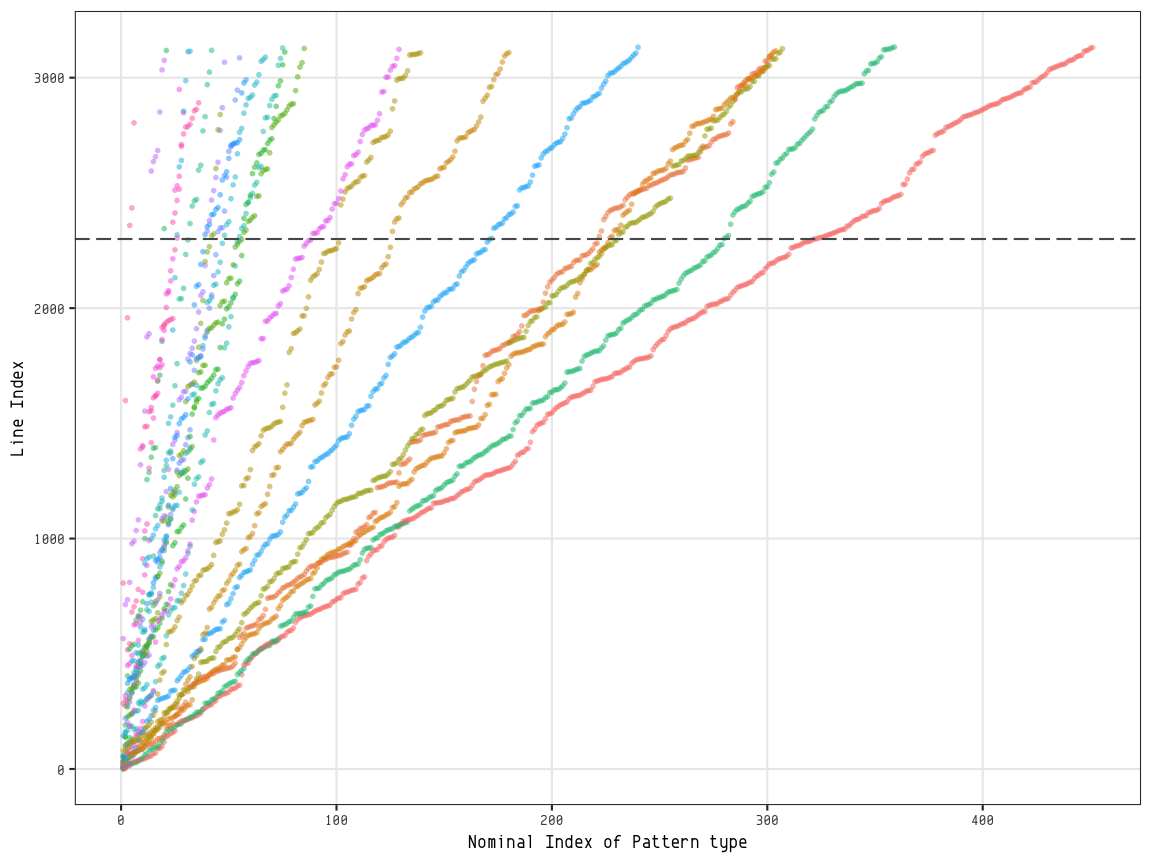

In [121]:
%%R -i by_idx_lines -u in -h 6 -w 8 -r 144

# even on this plot, we can see that the 'uniformity of slope' breaks down.
# we can also start to see changes in the relative 'densities' of the patterns

ggplot(data=by_idx_lines, aes(x=count,y=idx, color=type)) + 
geom_point(size=1, shape=16, alpha=0.5) +
geom_hline(yintercept=2300, linetype=5, color=grey(0.35)) +
theme_bw() +
labs(x="Nominal Index of Pattern type", y="Line Index") +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.position='none')

In [128]:
# Take a large sample with replacement from both sets and
# overlay them as a histogram, so we can see where the patterns differ

# Take this x-axis with a large pinch of salt, because the alignment issue
# has a huge effect on the full-line frequency counts. 

SAMP=100000
xsamp = random.choices(pre_lines, k=SAMP)
pre = list(zip(['pre']*SAMP, xsamp))
ysamp = random.choices(post_lines, k=SAMP)
post = list(zip(['post']*SAMP, ysamp))
s = pd.DataFrame(pre+post)
s.columns=['sample', 'pattern']
s.head()

sample pattern
0    pre      AB
1    pre      AC
2    pre      AB
3    pre      AC
4    pre      AD

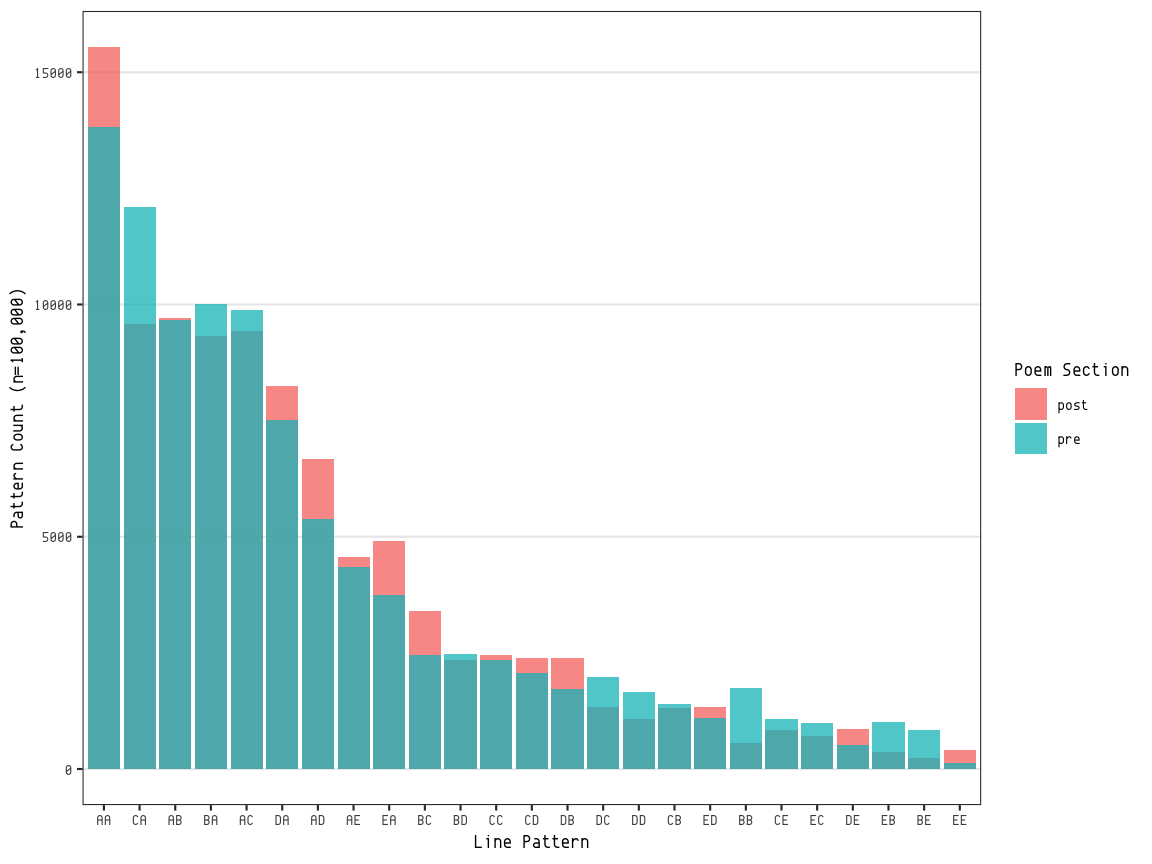

In [127]:
%%R -i s -h 6 -w 8 -u in -r 144

# i is gud coder
suppressWarnings(
    
ggplot(data=s, aes(x=fct_infreq(pattern))) +
geom_histogram(stat='count',aes(fill=sample), position='identity', alpha=0.75) + 
labs(x='Line Pattern', y="Pattern Count (n=100,000)") +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank()) + #, legend.position='none')
theme(panel.grid.major.x = element_blank()) +
guides(fill=guide_legend("Poem Section"))
    
)

In [69]:
# Now the rolling average again, but for all 25 patterns

CHUNKSZ=200
STEP=20
keys = set(beow_lines)
res=[]
for x in range(0,len(beow_lines)-CHUNKSZ,STEP):
    slice = beow_lines[x:x+CHUNKSZ]
    ctr = Counter(slice)
    obs={'chunk':x/STEP}
    for k in keys:
        obs[k] = ctr[k]/CHUNKSZ
    res.append(obs)
common = [x[0] for x in Counter(beow_lines).most_common()]
long = pd.DataFrame(res)[common + ['chunk']]

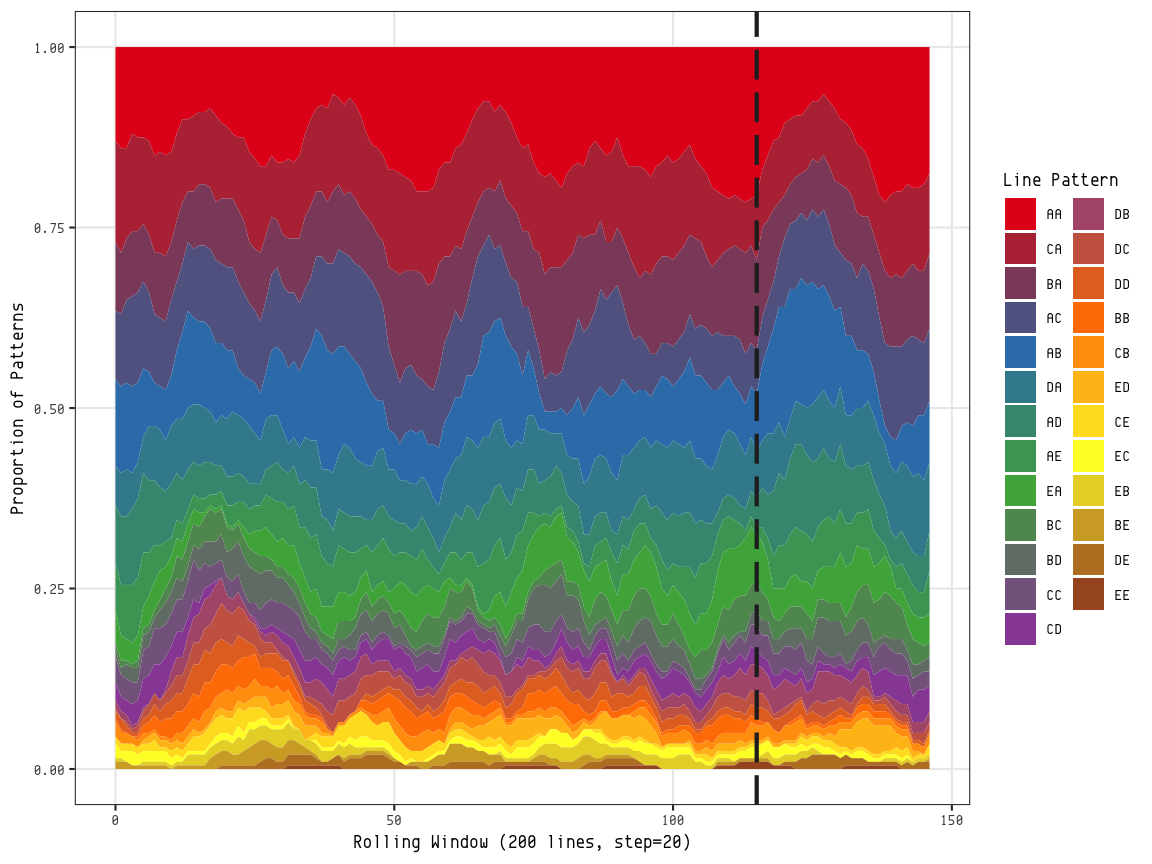

In [70]:
%%R -i long,STEP,CHUNKSZ -u in -w 8 -h 6 -r 144
library(RColorBrewer)
getPalette = colorRampPalette(brewer.pal(7, "Set1"))

df <- melt(long, id='chunk')
ggplot() + 
geom_area(position='stack', data=df, aes(x=chunk, y=value, fill=variable)) + 
geom_vline(xintercept = (2300)/STEP, col = grey(0.15), linetype=5, size = 1) +
theme_bw() +
scale_fill_manual(values = getPalette(25)) +
labs(x="Rolling Window (200 lines, step=20)", y="Proportion of Patterns") +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank()) + #, legend.position='none')
guides(fill=guide_legend("Line Pattern"))

In [71]:
# Statistical Analysis of the full line patterns

pre_full = get_counts(pre_lines, key_lines=beow_lines)
post_full = get_counts(post_lines, key_lines=beow_lines)

In [74]:
# This is the 'conservative' test. The null hypoth is that both sets of
# observations are drawn from the same distribution.

stat,p,_,_ = sp.stats.chi2_contingency([post_full,pre_full])
print("Chisquare test for Homogeneity: Score: %.2f p-value: %.4f" % (stat,p))

Chisquare test for Homogeneity: Score: 32.25 p-value: 0.1210


In [341]:
%%R -i pre_full,post_full

fisher.test(rbind(pre_full,post_full),simulate.p.value=TRUE)


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  rbind(pre_full, post_full)
p-value = 0.1014
alternative hypothesis: two.sided



In [115]:
# Using the newer data the result is essentially the same, neither 0.12
# nor 0.16 are statistically significant, although the numbers are
# low enough to look twice.

new_pre_full = get_counts(new_pre_lines, key_lines=new_beow_lines)
new_post_full = get_counts(new_post_lines, key_lines=new_beow_lines)
stat,p,_,_ = sp.stats.chi2_contingency([new_post_full,new_pre_full])
print("Chisquare test for Homogeneity: Score: %.2f p-value: %.4f" % (stat,p))

Chisquare test for Homogeneity: Score: 30.71 p-value: 0.1624


In [342]:
# This is the 'skeptical' test. The null hypoth is that the metrical
# distributions in the second part are the same as in the first.

stat, p = sp.stats.chisquare(post_full, pre_full/sum(pre_full)*sum(post_full))
print("Chisquare test for Goodness of Fit: Score: %.2f p-value: %.4f" % (stat,p))

Chisquare test for Goodness of Fit: Score: 42.53 p-value: 0.0112


In [77]:
# Again, using the new data, same result. Both scores are statistically
# significant at the 95% level. The overall statistical analysis is the same
# for the new data, although the alignment issue means that the individual
# pattern counts for full line patterns are probably nonsense.

stat, p = sp.stats.chisquare(new_post_full, new_pre_full/sum(new_pre_full)*sum(new_post_full))
print("Chisquare test for Goodness of Fit: Score: %.2f p-value: %.4f" % (stat,p))

Chisquare test for Goodness of Fit: Score: 40.68 p-value: 0.0181


In [116]:
# Now I'm going to do two bootstrap simulations, which seems more concrete
# (to me, anyway). I'm still going to use the chi-sq _statistic_
# as a general measure of distance between one count histogram
# and another, because it's a pretty standard tool, but I am
# not assuming that the results will follow the chi-square DISTRIBUTION.
#
# Instead we empirically count the same thing - how many random
# observations are more extreme than the score we observed.

In [81]:
def calc_score(obs=None,exp=None):
    
    '''Calculate the chi-square statistic for two distributions.
    
        The Expected data will be scaled so that the overall sum is
        the same as for the Observed data.
    
        In: obs, exp (List): Lists of items to compare.
        Out (float): The chi-square statistic
    '''
    
    obs_count = Counter(obs)
    exp_count = Counter(exp)
    o,e=[],[]
    for k in set(obs+exp):
        # scale obs values according to length of exp
        o.append(obs_count[k]/len(obs)*len(exp))
        e.append(exp_count[k])
    return stats.chisquare(o,e).statistic

In [79]:
# First we'll do the conservative version, the test for Homogeneity
# In this test we take the 'expected' frequencies from the whole
# set of observations (ie all the lines)

obs_homog = calc_score(obs=post_lines, exp=beow_lines)
obs_homog

88.9324810161582

In [80]:
TESTS = 50000
e_dist = []
samp = beow_lines[:]
for x in range(TESTS):
    # The null hypothesis for homogeneity is that post_lines
    # is basically a random sample from the whole poem, so we
    # take a random sample of that length and compare it to the
    # whole thing.
    e_dist.append(calc_score(obs=random.sample(beow_lines,k=len(post_lines)), exp=beow_lines))

In [82]:
# How many of the simulated results are more extreme than
# the distance we calculated as obs_homog?
#
# This should be roughly the same as the p-value from the
# test for homogeneity above (and it is).

emp_pval = len([x for x in e_dist if x >= obs_homog])/TESTS
emp_pval

0.11768

In [83]:
ed=pd.DataFrame(e_dist)
ed.columns=['score']

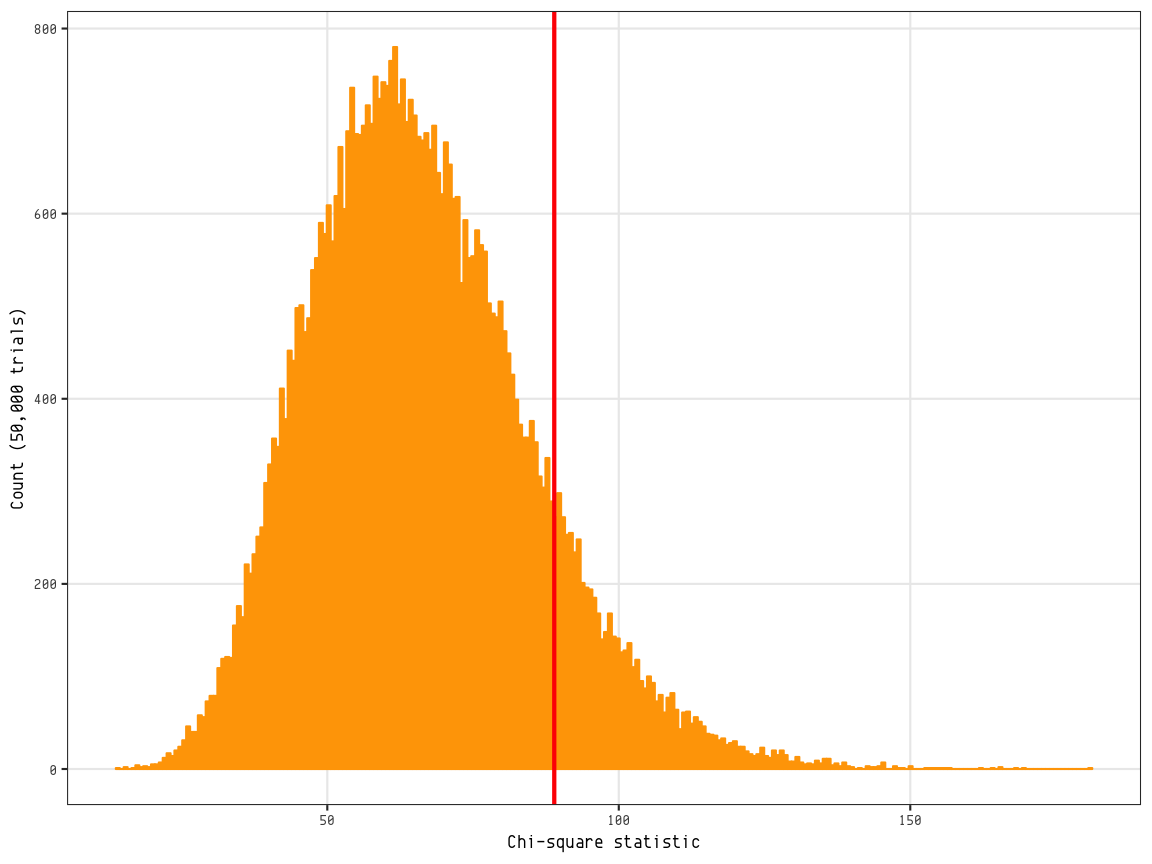

In [84]:
%%R -i ed,obs_homog -u in -w 8 -h 6 -r 144

ggplot(data=ed, aes(x=ed$score)) + geom_histogram(col = "orange", fill = "orange", bins=250) + 
geom_vline(xintercept = obs_homog, col = "red", size = 1) +
labs(x="Chi-square statistic", y="Count (50,000 trials)") +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank())

In [85]:
# Now the goodness of fit test

obs_fit = calc_score(obs=post_lines,exp=pre_lines)
obs_fit

117.30161684629107

In [86]:
e_dist_2 = []
for x in range(TESTS):
    # The null hypothesis here is that the distribution
    # of pre_lines is the same as the distribution of post_lines
    # which is slightly different. Here the procedure is to
    # take a sample from pre_lines and compare it to pre_lines
    # (NOT to the whole poem) and compare that to post_lines
    # versus pre_lines
    samp = random.choices(pre_lines, k=len(post_lines))
    e_dist_2.append(calc_score(obs=samp, exp=pre_lines))

In [87]:
# And this roughly matches the p-value from the goodness-of-fit test

len([x for x in e_dist_2 if x >= obs_fit])/TESTS

0.01326

In [88]:
ed2=pd.DataFrame(e_dist_2)
ed2.columns=['score']

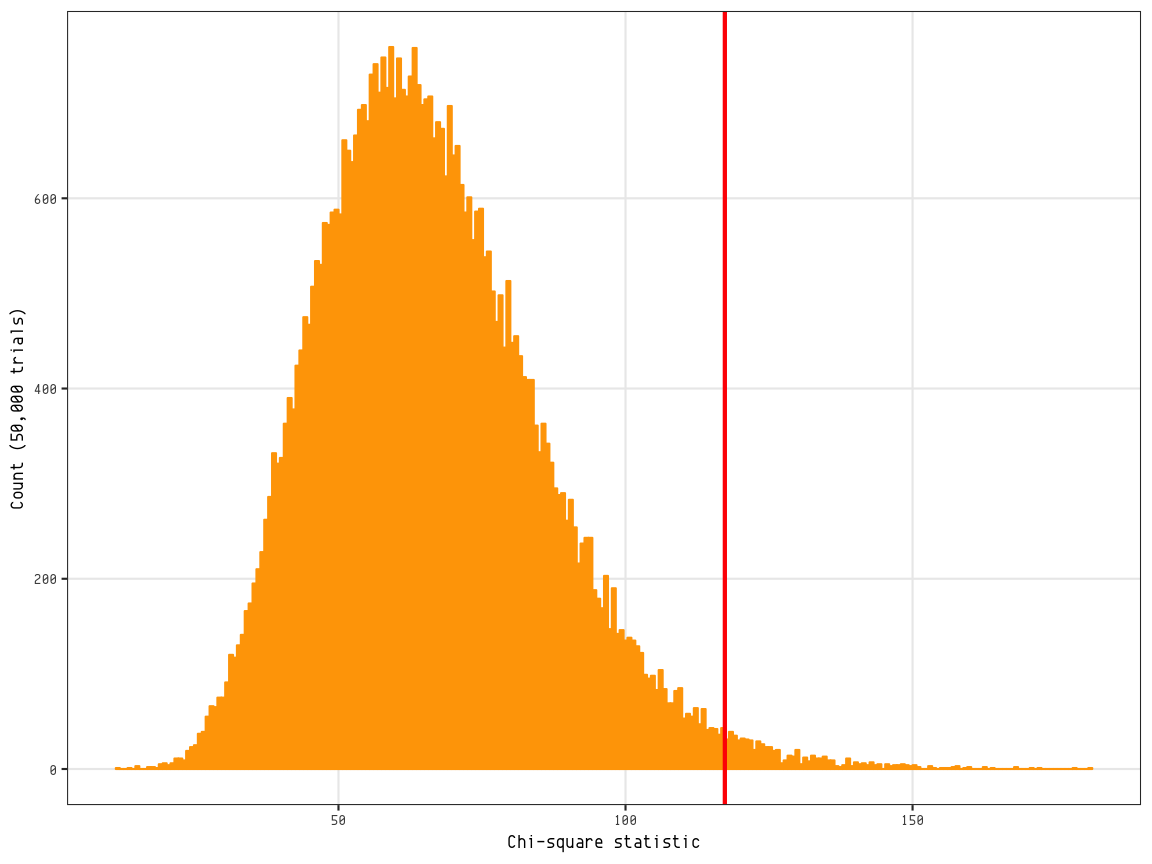

In [89]:
%%R -i ed2,obs_fit -u in -w 8 -h 6 -r 144

ggplot(data=ed2, aes(x=ed2$score)) + geom_histogram(col = "orange", fill = "orange", bins=250) + 
geom_vline(xintercept = obs_fit, col = "red", size = 1) +
labs(x="Chi-square statistic", y="Count (50,000 trials)") +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank())

In [90]:
# In my view, both of these simulations are defensible.
# The second test shows a statistically significant 
# difference between the distributions of full line patterns
# between the two parts.
#
# So, while I wouldn't push a claim that this is strong evidence
# for DIFFERENT authorship, I am very hesitant to accept metre as
# evidence in favour of a single author, which is the paper authors'
# claim.
#
# To clarify, again:
#
# Test 1 (conservative)
# Assume that Beowulf had a single author. Given that, how likely is it
# that we would see the metrical distribution in the post_lines?
#
# Test 2 (goodness-of-fit)
# Assume nothing. How likely is it that pre_lines and post_lines are both
# samples from the same underlying metrical distribution?